### Imports

In [51]:
from ase_interface import ANIENS
from ase_interface import ensemblemolecule
import hdnntools as hdt

import numpy as np
import ase

import time

import os
os.environ["OMP_NUM_THREADS"] = "2"

import  ase
from ase.md.langevin import Langevin
from ase.md.verlet import VelocityVerlet
from ase.io.trajectory import Trajectory
from ase import units
from ase.optimize import LBFGS
from ase.io import read, write
from ase.parallel import world
from ase import Atom, Atoms

import matplotlib.pyplot as plt

### Setup files to load (2LUF or TrpCage)

In [52]:
molfile = 'water.xyz'

ntdir = '/home/jsmith48/ANI-Networks/networks/ANI-1x_wcoulomb-3/'
cns = ntdir + 'rHCNO-5.0R_16-3.4A_a8-4.params'
sae = ntdir + 'sae_linfit.dat'
nnf = ntdir + 'train'
Nn = 4

### Load ANI models

In [53]:
# Setup NeuroChem
aens = ensemblemolecule(cns, sae, nnf, Nn, 0)

In [54]:
# Load molecule
mol = read(molfile)

# Set ANI calculator
mol.set_calculator(ANIENS(aens))

### Calculate energy and force

In [55]:
s_time = time.time()
E = mol.get_potential_energy()
F = mol.get_forces()
print('Total time:',time.time()-s_time)

print('Energy:',E)
print('Energy:',F)

spc = mol.get_chemical_symbols()
print('Number of atoms:',len(spc))

Total time: 0.013005256652832031
Energy: -2078.6069824246233
Energy: [[-0.03678723  0.04862085 -0.01844217]
 [-0.53465253 -0.38996035  0.14791547]
 [ 0.5714397   0.34133908 -0.1294733 ]]
Number of atoms: 3


### Optimize the system

In [56]:
# Optimize molecule
start_time = time.time()
dyn = LBFGS(mol)
dyn.run(fmax=0.00001,steps=5000)
print('[ANI Total time:', time.time() - start_time, 'seconds]')

# Save optimized mol
spc = mol.get_chemical_symbols()
pos = mol.get_positions(wrap=False).reshape(1,len(spc),3)

       Step     Time          Energy         fmax
LBFGS:    0 13:23:39    -2078.606982        0.6781
LBFGS:    1 13:23:39    -2078.616867        0.3617
LBFGS:    2 13:23:39    -2078.626645        0.2517
LBFGS:    3 13:23:39    -2078.627849        0.0282
LBFGS:    4 13:23:39    -2078.627858        0.0014
LBFGS:    5 13:23:39    -2078.627858        0.0001
LBFGS:    6 13:23:39    -2078.627858        0.0000
LBFGS:    7 13:23:39    -2078.627858        0.0000
[ANI Total time: 0.02858901023864746 seconds]


In [57]:
from ase.vibrations import Infrared
ir = Infrared(mol,delta=0.01)
ir.run()
ir.summary()

Writing ir.eq.pckl, dipole moment = (0.259757 -0.343669 0.130256)
Writing ir.0x-.pckl, dipole moment = (0.265175 -0.342925 0.129964)
Writing ir.0x+.pckl, dipole moment = (0.254148 -0.344354 0.130526)
Writing ir.0y-.pckl, dipole moment = (0.260491 -0.338251 0.131139)
Writing ir.0y+.pckl, dipole moment = (0.259021 -0.348900 0.129332)
Writing ir.0z-.pckl, dipole moment = (0.259465 -0.342752 0.137558)
Writing ir.0z+.pckl, dipole moment = (0.260022 -0.344535 0.122903)
Writing ir.1x-.pckl, dipole moment = (0.257494 -0.344169 0.130444)
Writing ir.1x+.pckl, dipole moment = (0.261888 -0.343126 0.130052)
Writing ir.1y-.pckl, dipole moment = (0.259165 -0.346799 0.129983)
Writing ir.1y+.pckl, dipole moment = (0.260327 -0.340510 0.130523)
Writing ir.1z-.pckl, dipole moment = (0.259968 -0.343924 0.126526)
Writing ir.1z+.pckl, dipole moment = (0.259527 -0.343406 0.133976)
Writing ir.2x-.pckl, dipole moment = (0.256447 -0.343844 0.130334)
Writing ir.2x+.pckl, dipole moment = (0.263046 -0.343459 0.1301

In [58]:
for i,f in zip(42.2561*ir.intensities,ir.get_frequencies()):
    print("{:10.3f}".format(i),"{:10.3f}".format(float(f.real)))

   158.637      0.000
     0.118      0.234
     0.011      0.468
     0.044      1.169
   119.304     15.763
   151.458     27.938
    95.958   1667.013
    16.157   3855.752
    96.605   3934.242


### Setup thermostat

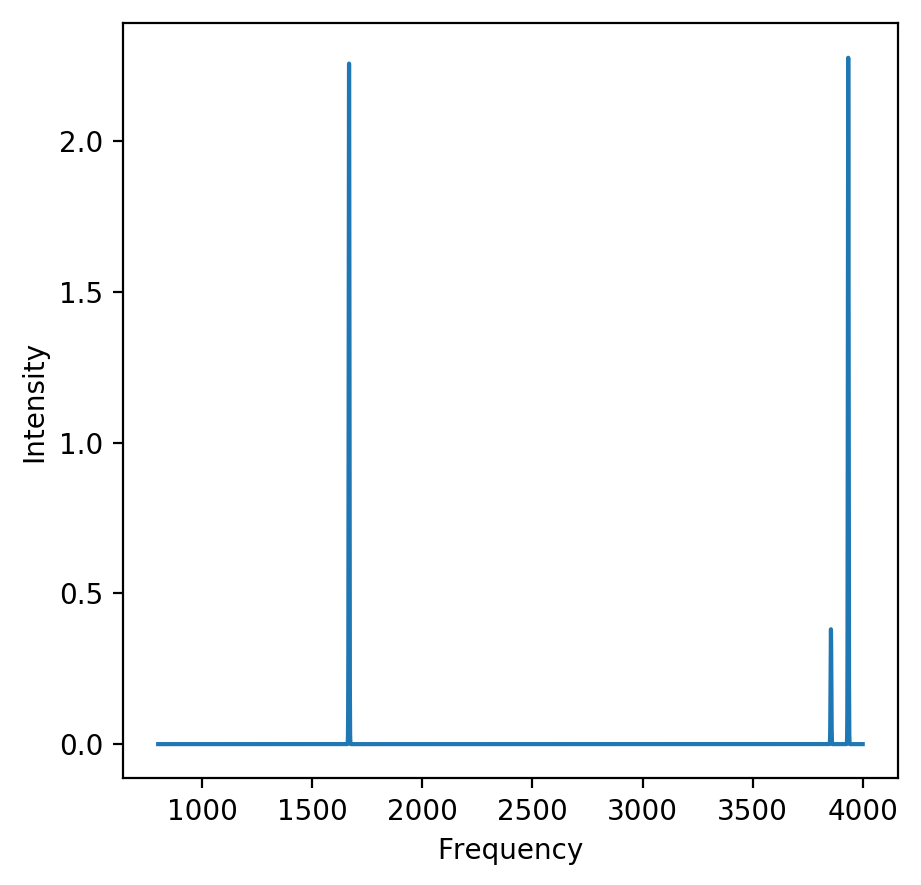

In [59]:
spec = ir.get_spectrum()

fig=plt.figure(figsize=(5, 5),dpi=200)
plt.plot(spec[0],spec[1])
plt.xlabel("Frequency")
plt.ylabel("Intensity")
plt.show()

In [60]:
ir.clean()

19

### Run MD

### Visualization